# Imports and General Settings

In [9]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

import os
import pathlib

import numpy as np

import io

import random

import pylab
import tfplot

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tfx
import tensorflow_transform as tft

from cleverhans.loss import SNNLCrossEntropy

# import self utility functions
import model_arch_utility as model_arch
import log_utility as log_util
import data_augmentation_utility as da_util
import load_data_utility as load_data_util

# tensorflow specific settings
tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

# which GPU to be used (0 is RTX, 1 or 2 are either of the Titan Xps)
gpu = "/GPU:0"

AUTOTUNE = tf.contrib.data.AUTOTUNE

session_config = tf.ConfigProto()
session_config.gpu_options.allow_growth = True
session_config.allow_soft_placement = True

# session_config.log_device_placement = True
tf.keras.backend.set_session(tf.Session(config=session_config))

# make sure tensorflow-gpu is being used
print(tf.test.gpu_device_name())

/device:GPU:0


# Data Augmentation

In [2]:
# data augmentation methods in data_augmentation_utility.py

# choose augmentation in load_data_utility.py

# ConvNet

## ConvNet Architecture

In [10]:
num_classes = 2

# ResNet-10 architecture
def convnet_network(x, conv_kernels=[10,7,3], num_channels=8, n_classes=num_classes, reuse = False, is_training = True):
    with tf.variable_scope('ConvNet', reuse = reuse), tf.device(gpu):
        
        x = tf.reshape(x, shape=[-1, 512, 512, 1])
        # channels
        
        filtered_images = []
        
        filtered_images.append(tf.identity(x))
        
        counter = 0
        for kernel in conv_kernels:
        
            x = model_arch.conv(x, num_channels, kernel=kernel, stride=2, padding='SAME', scope='conv_' + str(counter))
            x = model_arch.relu(x)
            
#             x = model_arch.max_pooling(x)
            
            x = model_arch.batch_norm(x, is_training, scope='batch_norm_' + str(counter))
            
            filtered_images.append(tf.identity(x))
            
            counter = counter + 1
            num_channels = num_channels * 2
 
        x_pre_flatten = tf.identity(x)
        
        x = model_arch.fully_connected(x, num_classes)
        
        return x, x_pre_flatten, filtered_images

    
def convnet_model_fn(features, labels, mode, conv_kernels=[10,7,3], num_channels=8, snnl_weight=0.05,
                      log=True):
    with tf.device(gpu):

        print("in gpu part")
        logits_train, activ_maps_train, filtered_images = convnet_network(features,
                                                                          conv_kernels=conv_kernels,
                                                                          num_channels=num_channels,
                                                                          n_classes=num_classes,
                                                                          reuse=False,
                                                                          is_training=True)
        
        logits_test, activ_maps_test, _ = convnet_network(features,
                                                          conv_kernels=conv_kernels,
                                                          num_channels=num_channels,
                                                          n_classes=num_classes,
                                                          reuse=False,
                                                          is_training=True)


        pred_classes = tf.arg_max(logits_test, dimension=1)

        # PREDICT MODE
        if mode == tf.estimator.ModeKeys.PREDICT:

            return tf.estimator.EstimatorSpec(mode=mode, predictions=pred_classes)


        loss_op = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
        # last layer SNNL
#         loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
#             model_arch.flatten(activ_maps_train), labels, 20.0, False)

        # first layer SNNL
        loss_op = (1.0 - snnl_weight) * loss_op + snnl_weight * SNNLCrossEntropy.optimized_temp_SNNL(
            model_arch.flatten(filtered_images[0]), labels, 20.0, False)
      
    
        acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
        
        if (not log):
            tf.summary.scalar("loss", loss_op)
            tf.summary.scalar("accuracy", acc_op[1])
        
        if mode == tf.estimator.ModeKeys.TRAIN:
                

            # the different ops for training, evaluating, ...
            estim_specs = tf.estimator.EstimatorSpec(
                mode=mode,
                predictions=pred_classes,
                loss=loss_op,
                train_op=train_op,
                eval_metric_ops={'accuracy': acc_op}
            )

            return estim_specs
    
#     for var in tf.trainable_variables():
#         print(var.name)

        if (log):

#             conv0_weights = [v for v in tf.global_variables() if v.name == "Resnet-10/conv_0/conv2d/kernel:0"][0]

#             plot_op_expanded = tf.expand_dims(log_util.plot_conv_weights(conv0_weights), 0)
#             tf.summary.image("conv_0_weight_plots", plot_op_expanded)


            with tf.name_scope("activation_maps"):

                counter = 0

                plot_ops = []

                for filtered_im in filtered_images:

                    name = "after_conv_" + str(counter)
                    if counter == 0:
                        name = "original_image:"
                    
                    activation_map = tf.slice(filtered_im,[0, 0, 0, 0],[1, -1, -1, -1])
                    activation_op = tf.expand_dims(log_util.plot_conv_output(activation_map, name), 0)

                    plot_ops.append(activation_op)

                    counter = counter + 1

                final_log_op = tf.concat(plot_ops, 2)

                tf.summary.image("image_display", final_log_op)
        
        eval_summary_hook = tf.train.SummarySaverHook(
            save_steps=1,
            output_dir=model_path + "/eval_images",
            summary_op=tf.summary.merge_all())
        # Add it to the evaluation_hook list
        evaluation_hooks = []
        evaluation_hooks.append(eval_summary_hook)

        # the different ops for training, evaluating, ...
        estim_specs = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss_op,
            train_op=train_op,
            eval_metric_ops={'accuracy': acc_op},
            evaluation_hooks=evaluation_hooks
        )

        return estim_specs

# Running Results

## Experimentation

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.summary.FileWriterCache.clear()
b_size = 32

learning_rate = 0.001

random_seed = 777

random.seed(a=random_seed)

num_steps = 10000

# convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_data_aug_no_norm/"

convnet_checkpoint_path_base = "/data/jma/model/binary_cnn/snnl_tests/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

# kernel_sizes = [[10, 7, 3]] v1

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0, 0.1, 0.2, 0.4]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)


dataset_root = "./data/generated_splits/2class/"

# sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]
sets = ["ali_relabeled_original", "ali_relabeled_undersampled"]


for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                train_root = dataset_root + dt_set + "/train/"
                eval_root = dataset_root + dt_set + "/eval/"
               
                train_paths = load_data_util.load_image_paths(train_root)
                random.shuffle(train_paths)

                print(train_root)
                
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                train_input_fn = lambda : load_data_util.load(train_root, train_paths, training=True, augment=False, batch_size=32, norm=False, shuffle=False)
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                print(model_path)

                config = tf.estimator.RunConfig(
                    log_step_count_steps= 20,
                    save_summary_steps= 30,
                    save_checkpoints_secs= 30,
                    model_dir=model_path,
                    tf_random_seed=random_seed,
                    session_config=session_config)

                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, config=config)

                train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps=num_steps)
                eval_spec = tf.estimator.EvalSpec(input_fn=eval_input_fn, throttle_secs=30)

                tf.estimator.train_and_evaluate(model, train_spec, eval_spec)

        

./data/generated_splits/2class/ali_relabeled_original/train/
/data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/', '_tf_random_seed': 777, '_save_summary_steps': 30, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 30, '_session_config': gpu_options {
  allow_growth: true
}
allow_soft_placement: true
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 20, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8d202b6390>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running

INFO:tensorflow:Saving dict for global step 675: accuracy = 0.80094784, global_step = 675, loss = 4.528676
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 675: /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-675
INFO:tensorflow:global_step/sec: 3.7981
INFO:tensorflow:loss = 1.0318895e-06, step = 680 (5.265 sec)
INFO:tensorflow:global_step/sec: 6.11413
INFO:tensorflow:loss = 1.7620506e-06, step = 700 (3.272 sec)
INFO:tensorflow:global_step/sec: 5.86769
INFO:tensorflow:loss = 2.1606617e-07, step = 720 (3.409 sec)
INFO:tensorflow:global_step/sec: 5.85958
INFO:tensorflow:loss = 1.8685694e-05, step = 740 (3.415 sec)
INFO:tensorflow:global_step/sec: 6.0216
INFO:tensorflow:loss = 4.2690426e-06, step = 760 (3.319 sec)
INFO:tensorflow:global_step/sec: 5.5915
INFO:tensorflow:loss = 1.3013525e-05, step = 780 (3.578 sec)
INFO:tensorflow:global_step/sec: 5.85079
INFO:tensorflow:loss = 3.725289e-08, step = 800 (3.418 sec)
INFO:tensorflow:globa

INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-05:47:03
INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.80094784, global_step = 1500, loss = 4.534769
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1500: /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-1500
INFO:tensorflow:global_step/sec: 3.33055
INFO:tensorflow:loss = 1.3485333e-06, step = 1500 (6.005 sec)
INFO:tensorflow:global_step/sec: 7.55411
INFO:tensorflow:loss = 8.0465816e-07, step = 1520 (2.647 sec)
INFO:tensorflow:global_step/sec: 5.64464
INFO:tensorflow:loss = 7.743927e-06, step = 1540 (3.546 sec)
INFO:tensorflow:global_step/sec: 6.76299
INFO:tensorflow:loss = 1.1175869e-08, step = 1560 (2.955 sec)
INFO:tensorflow:global_step/sec: 5.8289

INFO:tensorflow:global_step/sec: 6.29636
INFO:tensorflow:loss = 1.3895185e-06, step = 2320 (3.176 sec)
INFO:tensorflow:global_step/sec: 5.74713
INFO:tensorflow:loss = 2.0861594e-07, step = 2340 (3.480 sec)
INFO:tensorflow:Saving checkpoints for 2344 into /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21-05:49:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-2344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-05:49:34
INFO:tensorflow:Saving dict for global step 2344: accuracy = 0.80094784, global_step = 2344, loss = 4.547413
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2344: /data/jma/model/bi

INFO:tensorflow:global_step/sec: 6.62406
INFO:tensorflow:loss = 1.601872e-07, step = 3200 (3.019 sec)
INFO:tensorflow:Saving checkpoints for 3208 into /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21-05:52:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-3208
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-05:52:04
INFO:tensorflow:Saving dict for global step 3208: accuracy = 0.80094784, global_step = 3208, loss = 4.559539
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3208: /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-3208
INFO:tensorflow:global_step/s

INFO:tensorflow:global_step/sec: 5.90067
INFO:tensorflow:loss = 3.129235e-07, step = 3960 (3.390 sec)
INFO:tensorflow:global_step/sec: 5.6027
INFO:tensorflow:loss = 1.5646194e-07, step = 3980 (3.570 sec)
INFO:tensorflow:global_step/sec: 5.86788
INFO:tensorflow:loss = 3.3527606e-08, step = 4000 (3.407 sec)
INFO:tensorflow:global_step/sec: 6.15406
INFO:tensorflow:loss = 1.2665971e-07, step = 4020 (3.251 sec)
INFO:tensorflow:global_step/sec: 6.09719
INFO:tensorflow:loss = 6.3329885e-08, step = 4040 (3.279 sec)
INFO:tensorflow:Saving checkpoints for 4051 into /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21-05:54:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-4051
INFO:tensorflow:Running local_ini

INFO:tensorflow:global_step/sec: 3.46723
INFO:tensorflow:loss = 4.470347e-08, step = 4720 (5.767 sec)
INFO:tensorflow:global_step/sec: 7.76088
INFO:tensorflow:loss = 9.3132186e-08, step = 4740 (2.578 sec)
INFO:tensorflow:global_step/sec: 6.56442
INFO:tensorflow:loss = 2.4959394e-07, step = 4760 (3.046 sec)
INFO:tensorflow:global_step/sec: 6.02705
INFO:tensorflow:loss = 1.1660082e-06, step = 4780 (3.319 sec)
INFO:tensorflow:global_step/sec: 5.70692
INFO:tensorflow:loss = 1.8626433e-07, step = 4800 (3.505 sec)
INFO:tensorflow:global_step/sec: 5.77726
INFO:tensorflow:loss = 3.352755e-07, step = 4820 (3.461 sec)
INFO:tensorflow:global_step/sec: 6.25053
INFO:tensorflow:loss = 0.0, step = 4840 (3.200 sec)
INFO:tensorflow:global_step/sec: 5.56174
INFO:tensorflow:loss = 4.06054e-07, step = 4860 (3.597 sec)
INFO:tensorflow:global_step/sec: 5.43088
INFO:tensorflow:loss = 1.6763765e-07, step = 4880 (3.681 sec)
INFO:tensorflow:Saving checkpoints for 4886 into /data/jma/model/binary_cnn/snnl_tests/

INFO:tensorflow:global_step/sec: 5.77892
INFO:tensorflow:loss = 1.6391257e-07, step = 5600 (3.459 sec)
INFO:tensorflow:global_step/sec: 5.61717
INFO:tensorflow:loss = 3.0547298e-07, step = 5620 (3.560 sec)
INFO:tensorflow:global_step/sec: 6.16884
INFO:tensorflow:loss = 4.9173724e-07, step = 5640 (3.245 sec)
INFO:tensorflow:global_step/sec: 6.16858
INFO:tensorflow:loss = 4.470347e-08, step = 5660 (3.239 sec)
INFO:tensorflow:global_step/sec: 5.73838
INFO:tensorflow:loss = 7.8231054e-08, step = 5680 (3.486 sec)
INFO:tensorflow:global_step/sec: 6.01009
INFO:tensorflow:loss = 2.0489063e-07, step = 5700 (3.328 sec)
INFO:tensorflow:global_step/sec: 5.587
INFO:tensorflow:loss = 7.8603273e-07, step = 5720 (3.579 sec)
INFO:tensorflow:Saving checkpoints for 5735 into /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21-05:59:33


INFO:tensorflow:Finished evaluation at 2019-08-21-06:01:35
INFO:tensorflow:Saving dict for global step 6410: accuracy = 0.80094784, global_step = 6410, loss = 4.589356
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6410: /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-6410
INFO:tensorflow:global_step/sec: 3.79988
INFO:tensorflow:loss = 2.7194574e-07, step = 6420 (5.264 sec)
INFO:tensorflow:global_step/sec: 6.22509
INFO:tensorflow:loss = 4.0978176e-08, step = 6440 (3.212 sec)
INFO:tensorflow:global_step/sec: 6.01885
INFO:tensorflow:loss = 7.45058e-09, step = 6460 (3.323 sec)
INFO:tensorflow:global_step/sec: 5.76209
INFO:tensorflow:loss = 1.6391257e-07, step = 6480 (3.472 sec)
INFO:tensorflow:global_step/sec: 5.95126
INFO:tensorflow:loss = 3.6880283e-07, step = 6500 (3.360 sec)
INFO:tensorflow:global_step/sec: 5.51069
INFO:tensorflow:loss = 7.823103e-08, step = 6520 (3.630 sec)
INFO:tensorflow:global_step/sec: 5.72042
INFO:tensorf

INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (30 secs).
INFO:tensorflow:global_step/sec: 6.07389
INFO:tensorflow:loss = 7.823104e-08, step = 7260 (3.293 sec)
INFO:tensorflow:global_step/sec: 6.0237
INFO:tensorflow:loss = 4.0605607e-07, step = 7280 (3.320 sec)
INFO:tensorflow:global_step/sec: 6.11645
INFO:tensorflow:loss = 7.4505735e-08, step = 7300 (3.269 sec)
INFO:tensorflow:global_step/sec: 5.66735
INFO:tensorflow:loss = 6.1094624e-07, step = 7320 (3.531 sec)
INFO:tensorflow:global_step/sec: 6.30231
INFO:tensorflow:loss = 1.937149e-07, step = 7340 (3.171 sec)
INFO:tensorflow:global_step/sec: 6.0495
INFO:tensorflow:loss = 1.937149e-07, step = 7360 (3.307 sec)
INFO:tensorflow:global_step/sec: 5.91821
INFO:tensorflow:loss = 3.35276e-08, step = 7380 (3.378 sec)
INFO:tensorflow:global_step/sec: 5.67096
INFO:tensorflow:loss = 7.45058e-09, step = 7400 (3.527 sec)
INFO:tensorflow:global_step/sec: 6.24156
INFO:tensorflow:loss = 1.3783557e-07, step = 7420 (3.204 sec)
I

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-8119
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-06:06:36
INFO:tensorflow:Saving dict for global step 8119: accuracy = 0.80094784, global_step = 8119, loss = 4.601177
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8119: /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-8119
INFO:tensorflow:global_step/sec: 3.5001
INFO:tensorflow:loss = 1.3038496e-07, step = 8120 (5.712 sec)
INFO:tensorflow:global_step/sec: 7.6699
INFO:tensorflow:loss = 7.4505797e-09, step = 8140 (2.609 sec)
INFO:tensorflow:global_step/sec: 5.85192
INFO:tensorflow:loss = 2.4586882e-07, step = 8160 (3.418 sec)
INFO:tensorflow:global_step/sec: 6.58844
INFO:tensorflow:loss = 1.0803332e-07, step = 8180 (3.035 sec)
INF

INFO:tensorflow:loss = 9.685748e-08, step = 8920 (3.593 sec)
INFO:tensorflow:global_step/sec: 5.97546
INFO:tensorflow:loss = 0.0, step = 8940 (3.347 sec)
INFO:tensorflow:global_step/sec: 5.70416
INFO:tensorflow:loss = 1.0058278e-07, step = 8960 (3.506 sec)
INFO:tensorflow:Saving checkpoints for 8970 into /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21-06:09:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt-8970
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-06:09:06
INFO:tensorflow:Saving dict for global step 8970: accuracy = 0.80094784, global_step = 8970, loss = 4.607241
INFO:tensorflow:Saving 'checkpoint_pat

INFO:tensorflow:loss = 2.6077025e-08, step = 9680 (3.332 sec)
INFO:tensorflow:global_step/sec: 5.87902
INFO:tensorflow:loss = 9.6857505e-08, step = 9700 (3.404 sec)
INFO:tensorflow:global_step/sec: 5.64871
INFO:tensorflow:loss = 1.0430807e-07, step = 9720 (3.539 sec)
INFO:tensorflow:global_step/sec: 6.28356
INFO:tensorflow:loss = 4.8428753e-08, step = 9740 (3.182 sec)
INFO:tensorflow:global_step/sec: 5.58603
INFO:tensorflow:loss = 1.117587e-08, step = 9760 (3.580 sec)
INFO:tensorflow:global_step/sec: 5.91357
INFO:tensorflow:loss = 4.0978183e-08, step = 9780 (3.383 sec)
INFO:tensorflow:global_step/sec: 5.83714
INFO:tensorflow:loss = 3.3527595e-08, step = 9800 (3.429 sec)
INFO:tensorflow:Saving checkpoints for 9813 into /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.0/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21-06:11:35
INFO:tensorflow:Graph was finalized.
IN

INFO:tensorflow:global_step/sec: 5.88204
INFO:tensorflow:loss = 0.14563318, step = 280 (3.400 sec)
INFO:tensorflow:global_step/sec: 6.06063
INFO:tensorflow:loss = 0.21586812, step = 300 (3.304 sec)
INFO:tensorflow:global_step/sec: 5.53916
INFO:tensorflow:loss = 0.27819017, step = 320 (3.606 sec)
INFO:tensorflow:global_step/sec: 6.0333
INFO:tensorflow:loss = 0.17577735, step = 340 (3.315 sec)
INFO:tensorflow:Saving checkpoints for 345 into /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21-06:13:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.1/model.ckpt-345
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-06:13:16
INFO:tensor

INFO:tensorflow:loss = 0.10793208, step = 1060 (3.601 sec)
INFO:tensorflow:global_step/sec: 6.38707
INFO:tensorflow:loss = 0.92103434, step = 1080 (3.131 sec)
INFO:tensorflow:global_step/sec: 6.03576
INFO:tensorflow:loss = 0.14391188, step = 1100 (3.312 sec)
INFO:tensorflow:global_step/sec: 6.01301
INFO:tensorflow:loss = 0.21586633, step = 1120 (3.327 sec)
INFO:tensorflow:global_step/sec: 5.74217
INFO:tensorflow:loss = 0.14391032, step = 1140 (3.484 sec)
INFO:tensorflow:global_step/sec: 5.84054
INFO:tensorflow:loss = 0.10793227, step = 1160 (3.426 sec)
INFO:tensorflow:global_step/sec: 6.55288
INFO:tensorflow:loss = 0.14391021, step = 1180 (3.050 sec)
INFO:tensorflow:Saving checkpoints for 1195 into /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.1/model.ckpt.
INFO:tensorflow:Calling model_fn.
in gpu part
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-08-21-06:15:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restor

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1871: /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.1/model.ckpt-1871
INFO:tensorflow:global_step/sec: 3.8036
INFO:tensorflow:loss = 0.14391053, step = 1880 (5.257 sec)
INFO:tensorflow:global_step/sec: 5.44583
INFO:tensorflow:loss = 0.21586613, step = 1900 (3.673 sec)
INFO:tensorflow:global_step/sec: 5.72901
INFO:tensorflow:loss = 0.17988844, step = 1920 (3.492 sec)
INFO:tensorflow:global_step/sec: 5.72555
INFO:tensorflow:loss = 0.3237998, step = 1940 (3.494 sec)
INFO:tensorflow:global_step/sec: 5.84649
INFO:tensorflow:loss = 0.2518498, step = 1960 (3.420 sec)
INFO:tensorflow:global_step/sec: 5.68449
INFO:tensorflow:loss = 0.10793217, step = 1980 (3.518 sec)
INFO:tensorflow:global_step/sec: 5.79666
INFO:tensorflow:loss = 0.10793208, step = 2000 (3.452 sec)
INFO:tensorflow:global_step/sec: 5.86389
INFO:tensorflow:loss = 0.9210342, step = 2020 (3.408 sec)
INFO:tensorflow:Saving checkpoints for 2

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-06:20:18
INFO:tensorflow:Saving dict for global step 2706: accuracy = 0.81042653, global_step = 2706, loss = 3.9710786
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2706: /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.1/model.ckpt-2706
INFO:tensorflow:global_step/sec: 4.03194
INFO:tensorflow:loss = 0.107933775, step = 2720 (4.959 sec)
INFO:tensorflow:global_step/sec: 5.78629
INFO:tensorflow:loss = 0.32380038, step = 2740 (3.457 sec)
INFO:tensorflow:global_step/sec: 5.81646
INFO:tensorflow:loss = 0.21586655, step = 2760 (3.441 sec)
INFO:tensorflow:global_step/sec: 6.04113
INFO:tensorflow:loss = 0.2158666, step = 2780 (3.310 sec)
INFO:tensorflow:global_step/sec: 6.02836
INFO:tensorflow:loss = 0.39575878, step = 2800 (3.316 sec)
INFO:tensorflow:global_step/sec: 6.20286
INFO:tensorflow:loss = 0.14391048, step = 2

INFO:tensorflow:Starting evaluation at 2019-08-21-06:22:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.1/model.ckpt-3539
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-08-21-06:22:49
INFO:tensorflow:Saving dict for global step 3539: accuracy = 0.81042653, global_step = 3539, loss = 3.9588852
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3539: /data/jma/model/binary_cnn/snnl_tests/ali_relabeled_original_filter8_snnl0.1/model.ckpt-3539
INFO:tensorflow:global_step/sec: 3.40046
INFO:tensorflow:loss = 0.17988825, step = 3540 (5.882 sec)
INFO:tensorflow:global_step/sec: 7.89009
INFO:tensorflow:loss = 0.10793255, step = 3560 (2.535 sec)
INFO:tensorflow:global_step/sec: 6.11299
INFO:tensorflow:loss = 0.25184408, step = 3580 (3.271 sec)
INFO:tensorflow:global_step/sec: 6.05626
INFO:tensorf

## Evaluation

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

b_size = 32

learning_rate = 0.005

random_seed = 777

num_steps = 20000

convnet_checkpoint_path_base = "/data/jma/model/dataset_experiments/no_norm_no_data_aug/"

# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0]

# data_root = "./data/custom_activation_map_data/"

data_root = "./data/custom_activation_map_data/"

image_paths = load_data_util.load_image_paths(data_root)

eval_input_fn = lambda : load_data_util.load(data_root, image_paths, training=False, augment=False, batch_size=1, shuffle=False)


for filter_size in filter_sizes:
    for kernel_size in kernel_sizes:
        
        for snnl_weight in snnl_weights:
            tf.summary.FileWriterCache.clear()
 
            model_path = convnet_checkpoint_path_base + "original_new_labels/"
            print(model_path)

            model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                        conv_kernels=kernel_size, 
                                                                        num_channels=filter_size,
                                                                        snnl_weight=snnl_weight,
                                                                        log=True)

            model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

            model.evaluate(eval_input_fn)
              

/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/data/jma/model/dataset_experiments/no_data_aug/original_new_labels/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdd5fe1d438>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Call

# Metrics

## Metric Utility Functions

In [14]:
def path_to_label(paths, data_root):

    print(data_root)
    
    data_root = pathlib.Path(data_root)
    
    # return label names
    label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
    
    # assign index to label
    
    label_to_index = dict((name, index) for index,name in enumerate(label_names))

    print(label_to_index)
    
    # array of all labels corresponding to image_paths
    all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                        for path in paths]
    
    return all_image_labels



## Confusion Matrices

/data/jma/model/binary_cnn/initial_tests/ali_relabeled_original_filter8_snnl0.0/
./data/generated_splits/2class/ali_relabeled_original/eval/
{'0': 0, '1': 1, '2': 2}
in gpu part


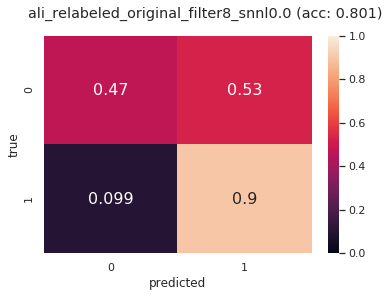

/data/jma/model/binary_cnn/initial_tests/ali_relabeled_original_filter8_snnl0.1/
./data/generated_splits/2class/ali_relabeled_original/eval/
{'0': 0, '1': 1, '2': 2}
in gpu part


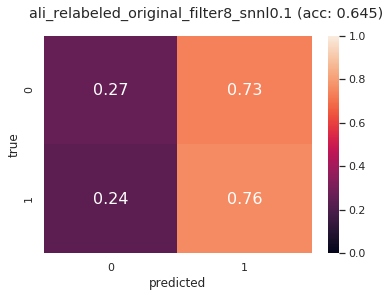

/data/jma/model/binary_cnn/initial_tests/ali_relabeled_original_filter8_snnl0.2/
./data/generated_splits/2class/ali_relabeled_original/eval/
{'0': 0, '1': 1, '2': 2}
in gpu part


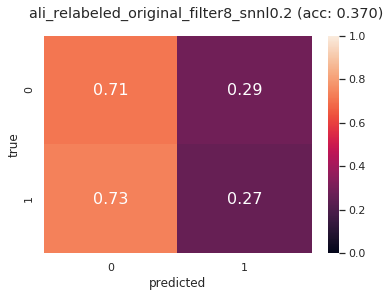

/data/jma/model/binary_cnn/initial_tests/ali_relabeled_original_filter8_snnl0.4/
./data/generated_splits/2class/ali_relabeled_original/eval/
{'0': 0, '1': 1, '2': 2}
in gpu part


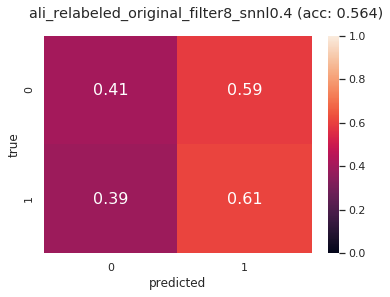

/data/jma/model/binary_cnn/initial_tests/ali_relabeled_undersampled_filter8_snnl0.0/
./data/generated_splits/2class/ali_relabeled_undersampled/eval/
{'0': 0, '1': 1, '2': 2}
in gpu part


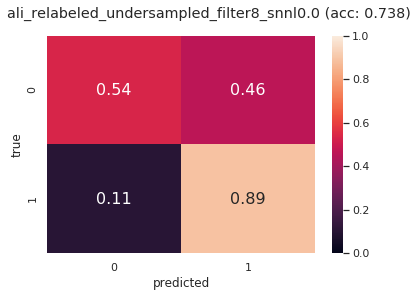

/data/jma/model/binary_cnn/initial_tests/ali_relabeled_undersampled_filter8_snnl0.1/
./data/generated_splits/2class/ali_relabeled_undersampled/eval/
{'0': 0, '1': 1, '2': 2}
in gpu part


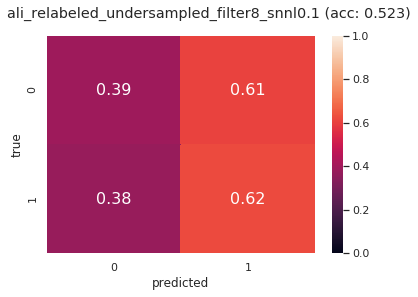

/data/jma/model/binary_cnn/initial_tests/ali_relabeled_undersampled_filter8_snnl0.2/
./data/generated_splits/2class/ali_relabeled_undersampled/eval/
{'0': 0, '1': 1, '2': 2}
in gpu part


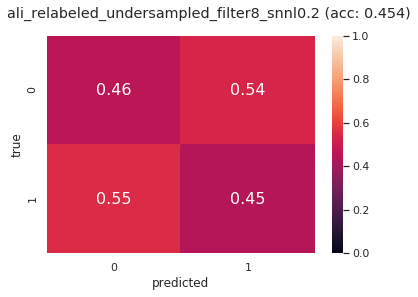

/data/jma/model/binary_cnn/initial_tests/ali_relabeled_undersampled_filter8_snnl0.4/
./data/generated_splits/2class/ali_relabeled_undersampled/eval/
{'0': 0, '1': 1, '2': 2}
in gpu part


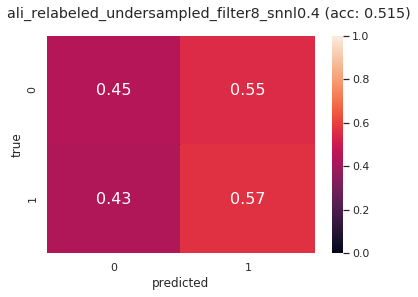

In [18]:
%matplotlib inline

import sklearn

tf.logging.set_verbosity(tf.logging.FATAL)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


tf.summary.FileWriterCache.clear()
b_size = 32


random_seed = 777

convnet_checkpoint_path_base = "/data/jma/model/binary_cnn/initial_tests/"


# kernel_sizes = [7, 9, 10, 11, 13]
# filter_sizes = [10]
# snnl_weights = [0.0]

kernel_sizes = [[10, 7, 3]]
filter_sizes = [8]
snnl_weights = [0.0, 0.1, 0.2, 0.4]

# data_root = "./data/data_relabeled_png_synthetic/"

# image_paths = load_data_util.load_image_paths(data_root)
# train_paths, eval_paths, test_paths = load_data_util.split(image_paths, seed=random_seed, split=[0.7, 0.1, 0.2])

# train_input_fn = lambda : load_data_util.load(data_root, train_paths, training=True, augment=False, batch_size=32, shuffle=False)
# eval_input_fn = lambda : load_data_util.load(data_root, eval_paths, training=False, augment=False, batch_size=32, shuffle=False)
# test_input_fn = lambda : load_data_util.load(data_root, test_paths, training=False, augment=False, shuffle=False)



        
dataset_root = "./data/generated_splits/2class/"

# sets = ["ali_relabeled_original", "peter_relabeled_original", "ali_relabeled_undersampled", "peter_relabeled_undersampled"]

sets = ["ali_relabeled_original", "ali_relabeled_undersampled"]


for dt_set in sets:
    for filter_size in filter_sizes:
        for kernel_size in kernel_sizes:

            for snnl_weight in snnl_weights:

                
                eval_root = dataset_root + dt_set + "/eval/"
                eval_paths = load_data_util.load_image_paths(eval_root)
                
                eval_input_fn = lambda : load_data_util.load(eval_root, eval_paths, training=False, augment=False, batch_size=32, norm=False, shuffle=False)


                
                model_path = convnet_checkpoint_path_base + dt_set + "_filter" + str(filter_size)+"_snnl" + str(snnl_weight) + "/"
                print(model_path)


                model_fn = lambda features, labels, mode: convnet_model_fn(features, labels, mode, 
                                                                            conv_kernels=kernel_size, 
                                                                             num_channels=filter_size,
                                                                            snnl_weight=snnl_weight,
                                                                            log=False)

                model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

               
                values = model.predict(eval_input_fn)


                original_labels = path_to_label(eval_paths, eval_root)
                predicted_labels = list(values)

                
                accuracy = sklearn.metrics.accuracy_score(original_labels, predicted_labels)
                
                cm = tf.confusion_matrix(original_labels, predicted_labels)
                cm = tf.to_float(cm)

                cm = cm.numpy()

                row_sums = cm.sum(axis=1)
                cm = cm / row_sums[:, np.newaxis]

                df_cm = pd.DataFrame(cm, range(2), range(2))
                #plt.figure(figsize = (10,7))
                
                sns.set(font_scale=1)#for label size
                plt.suptitle(dt_set + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + " (acc: " + str('%.3f'%(accuracy)) + ")")
                ax = sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, vmin=0, vmax=1.0)# font size
                ax.set(xlabel='predicted', ylabel='true')
                plt.show()

## Incorrectly Classified Images (PNG Format)

/data/jma/model/relabeled_data/resnet4/kernel5_filter8_snnl0.0/
in gpu part


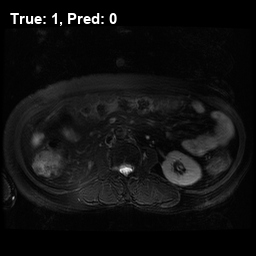

In [ ]:
%matplotlib inline

tf.logging.set_verbosity(tf.logging.ERROR)

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

resnet10_checkpoint_path_base = "/data/jma/model/relabeled_data/resnet4/"

data_path = "./data/data_relabeled_png/"

image_paths = load_image_paths(data_path)
train_paths, eval_paths, test_paths = split(image_paths, seed=random_seed)


train_input_fn = lambda : load(data_path, train_paths, training=True)
eval_input_fn = lambda : load(data_path, eval_paths, training=False)
test_input_fn = lambda : load(data_path, test_paths, training=False)

# change these======
working_paths = eval_paths
working_input_fn = eval_input_fn

kernel_size=5
filter_size=8
snnl_weight=0.0
#=========

model_path = resnet10_checkpoint_path_base + "kernel" + str(kernel_size) + "_filter" + str(filter_size) + "_snnl" + str(snnl_weight) + "/"
print(model_path)

model_fn = lambda features, labels, mode: resnet4_model_fn(features, labels, mode, 
                                                            conv_kernel=kernel_size, 
                                                            num_channels=filter_size)
model = tf.estimator.Estimator(model_fn=model_fn, model_dir=model_path)

values = model.predict(working_input_fn)

original_labels = path_to_label(working_paths, data_path)
predicted_labels = list(values)

# make a plot?

for index in range(len(working_paths)):
    if original_labels[index] != predicted_labels[index]:
        # add image to plot

        img = Image.open(working_paths[index])
        
        basewidth = 256

        wpercent = (basewidth/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))
        img = img.resize((basewidth,hsize), Image.ANTIALIAS)

        
        d = ImageDraw.Draw(img)
        
        # debug this shit
        d.text((10,10), "True: " + str(original_labels[index]) + 
               ", Pred: " + str(predicted_labels[index]), 
               fill="white", font=ImageFont.truetype("./fonts/arial-bold.ttf", 15))       
                
        display(img)
    